<a href="https://colab.research.google.com/github/shubham1262/Reco_Engine/blob/main/Recommendation_Model_Deep_Learning_TFRS_Ranking_Retreival.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# !pip install -q tensorflow-recommenders
# !pip install -q scann

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.2/96.2 KB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.5/10.5 MB 37.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 588.3/588.3 MB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 81.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 53.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 439.2/439.2 KB 32.6 MB/s eta 0:00:00


In [ ]:
import os
import pprint
import tempfile
from typing import Dict, Text
import numpy as np
import tensorflow as tf
import pandas as pd
import string
import re
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from ast import literal_eval
from datetime import datetime
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

import warnings
warnings.filterwarnings('ignore')

In [ ]:
import tensorflow_recommenders as tfrs

#Data Preprocessing
- Reading data from google drive

In [ ]:
video_data=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Rooters/Video_Data-2.csv',error_bad_lines=False, engine="python",sep= '\t')
interaction_data=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Rooters/User_Video_Interaction_Data-2.csv',sep= '\t')
user_data=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Rooters/User_Data-2.csv',sep= '\t')
impression_data=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Rooters/Impression_Data-2.csv',sep= '\t')

In [ ]:
video_data.columns

Index(['Unnamed: 0', 'feed_id', 'title', 'creator_type', 'genre_1', 'genre_2',
       'genre_3', 'game', 'lang', 'aspect', 'seconds_to_view', 'duration_min',
       'unique_viewers', 'watch_25', 'watch_100', 'likes', 'comments',
       'shares', 'ctr', 'creator_score', 'average'],
      dtype='object')

In [ ]:
video_data.head(2)

,Unnamed: 0,feed_id,title,creator_type,genre_1,genre_2,genre_3,game,lang,aspect,...,duration_min,unique_viewers,watch_25,watch_100,likes,comments,shares,ctr,creator_score,average
0,0,2365558821355722920,omg you’re so underrated 🥺,1000,7,0,0,5,hi,"720,1280",...,0-1,178,0,56,12,6,0,0.021696,4.00,2.0
1,1,7019053564166970674,aise toh Deewane mujhe pyaar,0,0,0,0,5,hi,"1024,1280",...,0-1,68,0,50,25,12,0,0.103030,0.01,3.0


In [ ]:
interaction_data.head(2)

,Unnamed: 0,user_id,feed_id,time_spent
0,0,669558848326440488,-6759540015890467708,41
1,1,6309124329467062111,-6759540015890467708,47


In [ ]:
user_data.head(2)

,Unnamed: 0,user_id,game_id
0,0,-1475653015642069795,5
1,1,-5431973823219341366,600916


In [ ]:
impression_data.head(2)

,Unnamed: 0,user_id,feed_id,impression
0,0,-5666044079884959429,-4066194066508426628,1
1,1,-4106946826626100761,8779021150976961603,1


# Video Data
- Dropping columns not relevant


In [ ]:
video_data['feed_id']=video_data['feed_id'].astype(str)

In [ ]:
video_data.drop(['Unnamed: 0','aspect','duration_min','average'], axis=1, inplace=True)
#Duration_min has different data types in it : not clean data
#Average is a score I believe, but I'll be creating score for these videos from scratch using few columns

In [ ]:
genre_map={1:'Contest', 2:'Funny',3:'Informative',4:'Lifestyle',5:'Moments',6:'Skills',7:'Gameplay', 8:'Entertainment'}

# Mapping genre
video_data['genre_1']=video_data['genre_1'].map(genre_map)
video_data['genre_2']=video_data['genre_2'].map(genre_map)
video_data['genre_3']=video_data['genre_3'].map(genre_map)

#Final genre is concatenation of genre_1, genre_2, genre_3
video_data['genre']=video_data['genre_1'].astype(str) + ' ' + video_data['genre_2'].astype(str) + ' ' + video_data['genre_3'].astype(str) 

video_data['genre'] = video_data['genre'].str.replace('nan','')
video_data['genre'] = video_data['genre'].str.strip()
video_data['genre'] = np.where(video_data['genre'] == '', 'Others',video_data['genre'])

video_data.drop(video_data[['genre_1','genre_2','genre_3']],axis=1,inplace=True)

- Mapping Game IDs

In [ ]:
video_data['game']=video_data['game'].astype(str)

video_data['game']=np.where(video_data['game']=='5','Free Fire',video_data['game'])
video_data['game']=np.where(video_data['game']=='2037279','Battle Ground Mobile India',video_data['game'])
video_data['game']=np.where(video_data['game']=='1636599','GTA-V',video_data['game'])
video_data['game']=np.where(video_data['game']=='20161','Minecraft',video_data['game'])
video_data['game']=np.where(video_data['game']=='600916','Free Fire Max',video_data['game'])
video_data['game']=np.where(video_data['game']=='15393','Valorant',video_data['game'])


- Adding game name in titles, for those which didnt have game names mentioned in them. Reason: Word Embeddings for recommendation model will work better with this addition in titles

In [ ]:
video_data['flag'] = video_data.apply(lambda x: x.game in x.title, axis=1)

video_data['title']=np.where(video_data['flag']==False,video_data['title'].astype(str)+', #'+video_data['game'].astype(str),video_data['title'])
video_data.drop(video_data[['flag']],axis=1,inplace=True)

- **[Important]** Creating an average score based on ['unique_viewers','watch_25','watch_100','likes', 'comments', 'shares', 'ctr', 'creator_score'] 

We could've taken weighted average of different column based on their importance, but for the assignment I've kept it simple. 
- 1. Normalizing data to be in 1-10 scale
- 2. Take average of all the scores and then normalize it again

In [ ]:
weighted_df=pd.DataFrame()

cols_to_normalize=['unique_viewers','watch_25','watch_100','likes', 'comments', 'shares', 'ctr', 'creator_score']

for col in cols_to_normalize:
  arr=video_data['unique_viewers'].to_numpy()
  start=1
  end=10
  width= end-start
  res=(arr-arr.min())/arr.ptp()*width+start #Normalizing on the scale of 1-10
  weighted_df[f'{col}_1_10'] = res.tolist()

weighted_df['video_score']=((weighted_df['unique_viewers_1_10']+weighted_df['watch_25_1_10']+weighted_df['watch_100_1_10']+weighted_df['likes_1_10']+weighted_df['comments_1_10']+weighted_df['shares_1_10']+weighted_df['ctr_1_10']+weighted_df['creator_score_1_10'])/8).round(2)

video_data = pd.concat([video_data,weighted_df],axis=1)
video_data.drop(['unique_viewers_1_10','watch_25_1_10','watch_100_1_10','likes_1_10','comments_1_10','shares_1_10','ctr_1_10','creator_score_1_10'],axis=1,inplace=True)

- CTR should be in percentage for easy read, so multiplying by 100

In [ ]:
video_data['ctr']=(video_data['ctr']*100).round(2)

- Splitting videos into two types: Reels and Videos

In [ ]:
video_data['feed_type']=np.where(video_data['seconds_to_view']<=60,'Reel','Video')
video_data.drop(columns=['seconds_to_view'],axis=1,inplace=True)

In [ ]:
video_data_cleaned=video_data

# Interaction Data, User_Data, Impressions_data 

In [ ]:
interaction_data.drop(interaction_data[['Unnamed: 0']],axis=1,inplace=True)
user_data.drop(user_data[['Unnamed: 0']],axis=1,inplace=True)
impression_data.drop(impression_data[['Unnamed: 0']],axis=1,inplace=True)

# Converting int to string
interaction_data['feed_id']=interaction_data['feed_id'].astype(str)
interaction_data['user_id']=interaction_data['user_id'].astype(str)

user_data['user_id']=user_data['user_id'].astype(str)

impression_data['feed_id']=impression_data['feed_id'].astype(str)
impression_data['user_id']=impression_data['user_id'].astype(str)

In [ ]:
#Inner join (Interaction and Impression) to reduce sparsity of data. In real world we could've done an outer join and imputed the missing values.
Interaction_Impression=pd.merge(interaction_data,impression_data,on=['user_id','feed_id'],how='inner') 

In [ ]:
# An user is following multiple games, so removing duplicated user-game mapping by grouping all games liked by user into one row

user_data['game_id']=user_data['game_id'].astype('str')

user_data['game_id']=np.where(user_data['game_id']=='5','Free Fire',user_data['game_id'])
user_data['game_id']=np.where(user_data['game_id']=='2037279','Battle Ground Mobile India',user_data['game_id'])
user_data['game_id']=np.where(user_data['game_id']=='1636599','GTA-V',user_data['game_id'])
user_data['game_id']=np.where(user_data['game_id']=='20161','Minecraft',user_data['game_id'])
user_data['game_id']=np.where(user_data['game_id']=='600916','Free Fire Max',user_data['game_id'])
user_data['game_id']=np.where(user_data['game_id']=='15393','Valorant',user_data['game_id'])

user_game_followed=pd.DataFrame(user_data.groupby('user_id')['game_id'].apply(list).to_dict().items(), columns=['user_id', 'games_followed']) 
user_game_followed['games_followed']=[', '.join(map(str, l)) for l in user_game_followed['games_followed']]

In [ ]:
# Joining Interaction, Impression and User like data
Interaction_Impression_User=pd.merge(Interaction_Impression,user_game_followed,on=['user_id'],how='left')

- Final Data Sets are ready

### Joining User level data with feed metadata

In [ ]:
final_data=pd.merge(Interaction_Impression_User,video_data_cleaned[['feed_id','title','creator_type','game','lang','genre','feed_type','video_score']],on=['feed_id'],how='left')

# Final Scoring

> We are penalizing video_score(0.3) (how good a video is doing world wide), to make sure that we are not biased towards popular content

In [ ]:
final_data['video_score'].fillna(final_data['video_score'].mean(),inplace=True)

final_data['score'] = final_data['time_spent']*0.5 + final_data['impression']*0.2 + final_data['video_score']*0.3


arr=final_data['score'].to_numpy()
start=1
end=10
width= end-start
res=(arr-arr.min())/arr.ptp()*width+start #Normalizing on the scale of 1-10
final_data['score'] = res.tolist()

# EDA

> I like to use Tableau or Looker for faster EDA and better looking graphs.

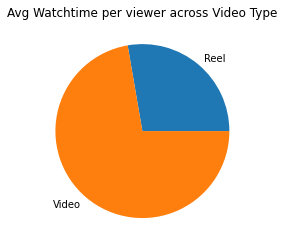

In [ ]:
user_count=final_data['user_id'].nunique()
avg_time_feedtype=final_data.groupby(['feed_type'])['time_spent'].agg(['mean']).reset_index()
avg_time_feedtype['watch_time_per_feed']=(avg_time_feedtype['mean']/user_count)*1000000
plt.pie(avg_time_feedtype['watch_time_per_feed'], labels=avg_time_feedtype['feed_type'])
plt.title('Avg Watchtime per viewer across Video Type')
plt.show()

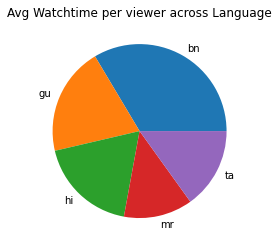

In [ ]:
user_count=final_data['user_id'].nunique()
avg_time_lang=final_data.groupby(['lang'])['time_spent'].agg(['mean']).reset_index()
avg_time_lang['watch_time_per_game']=(avg_time_lang['mean']/user_count)*1000000
plt.pie(avg_time_lang['watch_time_per_game'], labels=avg_time_lang['lang'])
plt.title('Avg Watchtime per viewer across Language')
plt.show()

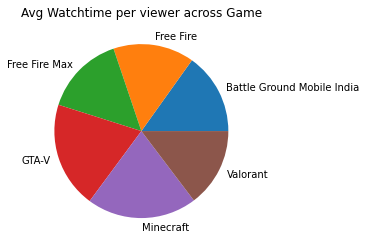

In [ ]:
user_count=final_data['user_id'].nunique()
avg_time_game=final_data.groupby(['game'])['time_spent'].agg(['mean']).reset_index()
avg_time_game['watch_time_per_game']=(avg_time_game['mean']/user_count)*1000000
plt.pie(avg_time_game['watch_time_per_game'], labels=avg_time_game['game'])
plt.title('Avg Watchtime per viewer across Game')
plt.show()

In [ ]:
video_data_cleaned['completion_rate']=video_data_cleaned['watch_100']/video_data_cleaned['unique_viewers'] #Adding a feature called completion rate

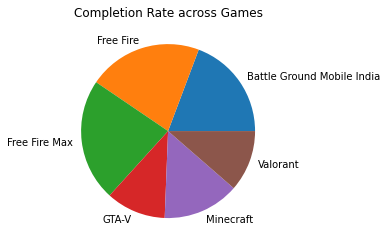

In [ ]:
completion_rate=video_data_cleaned.groupby(['game'])['completion_rate'].agg(['mean']).reset_index()
completion_rate['watch_time_per_game']=(completion_rate['mean'])*100
plt.pie(completion_rate['watch_time_per_game'], labels=completion_rate['game'])
plt.title('Completion Rate across Games')
plt.show()

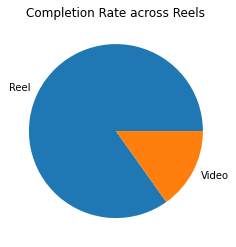

In [ ]:
completion_rate=video_data_cleaned.groupby(['feed_type'])['completion_rate'].agg(['mean']).reset_index()
completion_rate['watch_time_per_game']=(completion_rate['mean'])*100
plt.pie(completion_rate['watch_time_per_game'], labels=completion_rate['feed_type'])
plt.title('Completion Rate across Reels')
plt.show()

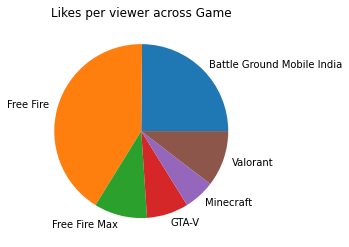

In [ ]:
user_count=final_data['user_id'].nunique()
avg_time_game=video_data_cleaned.groupby(['game'])['likes'].agg(['mean']).reset_index()
avg_time_game['watch_time_per_game']=(avg_time_game['mean']/user_count)*1000000
avg_time_game
plt.pie(avg_time_game['watch_time_per_game'], labels=avg_time_game['game'])
plt.title('Likes per viewer across Game')
plt.show()

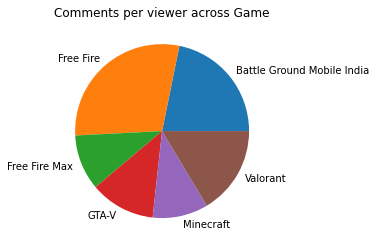

In [ ]:
user_count=final_data['user_id'].nunique()
avg_time_game=video_data_cleaned.groupby(['game'])['comments'].agg(['mean']).reset_index()
avg_time_game['watch_time_per_game']=(avg_time_game['mean']/user_count)*1000000
plt.pie(avg_time_game['watch_time_per_game'], labels=avg_time_game['game'])
plt.title('Comments per viewer across Game')
plt.show()

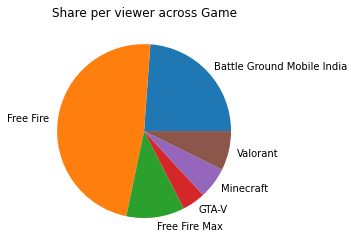

In [ ]:
user_count=final_data['user_id'].nunique()
avg_time_game=video_data_cleaned.groupby(['game'])['shares'].agg(['mean']).reset_index()
avg_time_game['watch_time_per_game']=(avg_time_game['mean']/user_count)*1000000
plt.pie(avg_time_game['watch_time_per_game'], labels=avg_time_game['game'])
plt.title('Share per viewer across Game')
plt.show()

# Modelling ( 2 Tower Model for Recommendation) Used by Youtube with Context
https://research.google.com/pubs/archive/45530.pdf

#### Note: Code for 2 Tower Model, aka candidate generation and Retreival model ***using Context*** is not available on the internet. I have implemented this for zee5

- Converting pandas data frames to tensor dataframes for modelling

In [ ]:
# Converting all non object type to onject type so that while converting pandas data frame to tensorflow onject, it doesnt throw an error
for columns in final_data:
  if(final_data[columns].dtypes!='object'):
    final_data[columns]=final_data[columns].astype(str)

for columns in video_data_cleaned:
  if(video_data_cleaned[columns].dtypes!='object'):
    video_data_cleaned[columns]=video_data_cleaned[columns].astype(str)

final_data=final_data.dropna() #To avoid error while converting to tensorflow dataframe

In [ ]:
ratings = tf.data.Dataset.from_tensor_slices(dict(final_data))
#Video_data_cleaned contains the list of titles, aka corpus of video titles. This will be used to create an embedding layer, so if a user doesn't have rating for a title, we'll take that as an
# implicit negative feedback. If a user does have a score then it'll be an implicit positive feedback
videos = tf.data.Dataset.from_tensor_slices(dict(video_data_cleaned)) 

ratings = ratings.map(lambda x: {
    "video_title": x["title"],
    "user_id": x["user_id"],
    "rating": float(x["score"]),
    "feed_type": x["feed_type"],
    "game": x["game"],
    "genre": x["genre"]
})

videos = videos.map(lambda x: { "video_title":x["title"],
                                "feed_id": x["feed_id"]                               
                               })
videos = videos.map(lambda x: x["video_title"])

# Feature Preprocessing using tensorflow.keras

### Preprocessing using tf.keras.layers

####String
- StringLookup, This will represent string categorical values as integers (uses adapt): https://www.tensorflow.org/api_docs/python/tf/keras/layers/StringLookup
- TextVectorization, This will clean up the data (language) (uses adapt): https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization

####Integer
- Normalization layer to normalize continous columns : https://www.tensorflow.org/api_docs/python/tf/keras/layers/Normalization
- IntegerLookup, To represent as one-hot, multi-hot encoding (uses adapt)
- CategoryEncoding, To represent integer categorical values as one-hot or multi-hot, when size of vocab is known https://www.tensorflow.org/api_docs/python/tf/keras/layers/CategoryEncoding


In [ ]:
# Normalization (Numerical Columns)
def get_normalization_adapt_layer(name, dataset):

  normalizer = tf.keras.layers.Normalization(axis=None)
  feature_ds = dataset.map(lambda x: x[name])
  normalizer.adapt(feature_ds)

  return normalizer

In [ ]:
#Categorical Adapt Layer
def get_categorical_adapt_layer(name, dataset, dtype, max_tokens=None):

  if dtype == 'string':
    index = tf.keras.layers.StringLookup(max_tokens=max_tokens)
  else:
    index = tf.keras.layers.IntegerLookup(max_tokens=max_tokens)

  feature_ds = dataset.map(lambda x: x[name])
  index.adapt(feature_ds)

  return index

In [ ]:
#Text Vectorizer Layer
def text_vectorize_adapt(name,dataset,max_tokens=None):

  vectorizer=tf.keras.layers.experimental.preprocessing.TextVectorization()
  feature_ds = dataset.map(lambda x: x[name])
  vectorizer.adapt(feature_ds)

  return vectorizer

- We wouldn't be using this due to limited RAM availability

# Preprocessing features manually

In [ ]:
unique_video_title = np.unique(np.concatenate(list(videos.batch(1_00)))) # For Retreival Model, we need embedding for the corpus
unique_user_ids = np.unique(np.concatenate(list(ratings.batch(1_00).map(lambda x: x["user_id"]))))
feed_types = np.unique(np.concatenate(list(ratings.batch(1_00).map(lambda x: x["feed_type"])))) # To add context in the model's retreival and ranking phase
game_types = np.unique(np.concatenate(list(ratings.batch(1_00).map(lambda x: x["game"])))) # To add context in the model's retreival and ranking phase
genre_types = np.unique(np.concatenate(list(ratings.batch(1_00).map(lambda x: x["genre"])))) # To add context in the model's retreival and ranking phase

# User Model with Context

#### Note: For demonstration purpose I've added **feed_type** (reel or video) as context in the whole model

In [ ]:
class UserModel(tf.keras.Model):
  
  def __init__(self):
    super().__init__()

    self.user_embedding = tf.keras.Sequential([
        tf.keras.layers.StringLookup(
            vocabulary=unique_user_ids, mask_token=None),
        tf.keras.layers.Embedding(len(unique_user_ids) + 1, 32),
    ])
# Adding context (feed_types and game type) embeddings to the model
    self.feed_types_embedding = tf.keras.Sequential([
        tf.keras.layers.StringLookup(
            vocabulary=feed_types, mask_token=None),
        tf.keras.layers.Embedding(len(feed_types) + 1, 2),
    ])   

    self.game_types_embedding = tf.keras.Sequential([
        tf.keras.layers.StringLookup(
            vocabulary=game_types, mask_token=None),
        tf.keras.layers.Embedding(len(game_types) + 1, 2),
    ])   

    self.genre_types_embedding = tf.keras.Sequential([
        tf.keras.layers.StringLookup(
            vocabulary=genre_types, mask_token=None),
        tf.keras.layers.Embedding(len(genre_types) + 1, 2),
    ]) 


  def call(self, inputs):
    return tf.concat([
        self.user_embedding(inputs["user_id"]),
        self.feed_types_embedding(inputs["feed_type"]), #Passing concatenation of encoding of users and context(feed_type)
        self.game_types_embedding(inputs["game"]),
        self.genre_types_embedding(inputs["genre"])
    ], axis=1)

# Video Model

In [ ]:
class VideoModel(tf.keras.Model):
  
  def __init__(self):
    super().__init__()

    max_tokens = 10_000

    self.title_embedding = tf.keras.Sequential([
      tf.keras.layers.StringLookup(
          vocabulary=unique_video_title, mask_token=None),
      tf.keras.layers.Embedding(len(unique_video_title) + 1, 32)
    ])

# Title Vectorizations and embedding to let model learn meanings of words in the title
    self.title_vectorizer = tf.keras.layers.TextVectorization(
        max_tokens=max_tokens)

    self.title_text_embedding = tf.keras.Sequential([
      self.title_vectorizer,
      tf.keras.layers.Embedding(max_tokens, 32, mask_zero=True),
      tf.keras.layers.GlobalAveragePooling1D(),
    ])

    self.title_vectorizer.adapt(videos)

  def call(self, inputs):
    output=tf.concat([
        self.title_embedding(inputs),
        self.title_text_embedding(inputs)
    ], axis=1)
    return output

# Combining candidate generation and Ranking algorithms

- Retrieval Task (High Precision)

Retrieval is getting a list of videos that might get better engagement. Since we have to filter few 100s of videos from a lot of videos, we have to trade off between performance and time

> To measure the performance of a Retrieval task, **factorized top-K categorical** accuracy metrics over a corpus of candidates can be used. These metrics measure how good the model is at picking the true candidate out of all possible candidates in the system.

>For example, a top-5 categorical accuracy metric of 0.2 would tell us that, on average, the true positive is in the top 5 retrieval items 20% of the time.

- Ranking task (High Recall)

Ranking is scoring videos got from Retrieval model. Since, we have to deal with less videos, we can build a complex model (like below) for Ranking

>This time we are going to predict rating value as the objective. So like the other regression problems we can use **MSE (Mean Squared Error)** as loss function and **RMSE (Root Mean Squared Error)** as an accuracy metric.

- Prediction of rating (explicit)

>We can create a complex deep learning model to predict ratings based on features

In [ ]:
class YoutubeModel(tfrs.models.Model):

  def __init__(self, rating_weight: float, retrieval_weight: float) -> None:
    # We take the loss weights in the constructor: this allows us to instantiate
    # several model objects with different loss weights.

    super().__init__()

    embedding_dimension = 32 # We can play with this to improve model's performance

# For Retreival
    self.query_model = tf.keras.Sequential([
      UserModel(),
      tf.keras.layers.Dense(32)
    ])

    self.candidate_model = tf.keras.Sequential([
      VideoModel(),
      tf.keras.layers.Dense(32)
    ])

# For Ranking
    self.user_model: tf.keras.layers.Layer = tf.keras.Sequential([
      tf.keras.layers.StringLookup(
        vocabulary=unique_user_ids, mask_token=None),
      tf.keras.layers.Embedding(len(unique_user_ids) + 1, 32)
    ])
# Adding context(feed_type, game, genre) to ranking algorithm
    self.feed_type_embedding = tf.keras.Sequential([
        tf.keras.layers.StringLookup(
            vocabulary=feed_types, mask_token=None),
        tf.keras.layers.Embedding(len(feed_types) + 1, 32)
    ])  

    self.game_type_embedding = tf.keras.Sequential([
        tf.keras.layers.StringLookup(
            vocabulary=game_types, mask_token=None),
        tf.keras.layers.Embedding(len(game_types) + 1, 32)
    ]) 

    self.genre_type_embedding = tf.keras.Sequential([
        tf.keras.layers.StringLookup(
            vocabulary=genre_types, mask_token=None),
        tf.keras.layers.Embedding(len(genre_types) + 1, 32)
    ]) 
    

    self.video_model: tf.keras.layers.Layer = tf.keras.Sequential([
      tf.keras.layers.StringLookup(
        vocabulary=unique_video_title, mask_token=None),
      tf.keras.layers.Embedding(len(unique_video_title) + 1, 32)
    ])  


    self.rating_model = tf.keras.Sequential([
        tf.keras.layers.Dense(256, activation="relu"),
        tf.keras.layers.Dense(128, activation="relu"),
        tf.keras.layers.Dense(1),
    ])

    # Loss Functions for retreival and ranking alogorithms
    self.rating_task: tf.keras.layers.Layer = tfrs.tasks.Ranking(
        loss=tf.keras.losses.MeanSquaredError(),
        metrics=[tf.keras.metrics.RootMeanSquaredError()],
    )
    self.retrieval_task: tf.keras.layers.Layer = tfrs.tasks.Retrieval(
        metrics=tfrs.metrics.FactorizedTopK(
            candidates=videos.batch(128).map(self.candidate_model)
        )
    )


    self.rating_weight = rating_weight
    self.retrieval_weight = retrieval_weight


  def call(self, features, training=False):

    user_embeddings=tf.concat([
        self.user_model(features["user_id"]),
        self.feed_type_embedding(features["feed_type"]),
        self.game_type_embedding(features["game"]),
        self.genre_type_embedding(features["genre"])
    ], axis=1)

    video_embeddings = self.video_model(features["video_title"])
    

    return (
        user_embeddings,
        video_embeddings,
        self.rating_model(
            tf.concat([user_embeddings, video_embeddings], axis=1)
        ),
    )

  def compute_loss(self, features, training=False):

    ratings = features.pop("rating")

    user_embeddings, video_embeddings, rating_predictions = self(features)

# Rating Loss
    rating_loss = self.rating_task(
        labels=ratings,
        predictions=rating_predictions,
    )

# Create different embeddings for retreival task function
    query_embeddings = self.query_model({
        "user_id": features["user_id"]
        ,"feed_type": features["feed_type"] 
        ,"game": features["game"]      
        ,"genre": features["genre"]    
        })
    video_embeddings = self.candidate_model({
        "video_title": features["video_title"]    
        })
# Retreival Loss    
    retrieval_loss = self.retrieval_task(query_embeddings, video_embeddings)


    # And combine them using the loss weights.
    return (self.rating_weight * rating_loss
        + self.retrieval_weight * retrieval_loss)

In [ ]:
tf.random.set_seed(42)
shuffled = ratings.shuffle(100_000, seed=42, reshuffle_each_iteration=False)

train = shuffled.take(80_00)
test = shuffled.skip(80_0).take(20_00)

cached_train = train.shuffle(100_000).batch(1000)
cached_test = test.batch(2090).cache()

In [ ]:
model = YoutubeModel(rating_weight=1.0, retrieval_weight=1.0)
model.compile(optimizer=tf.keras.optimizers.Adagrad(0.1))
model.fit(cached_train, epochs=10)

Epoch 1/10


8/8 [==============================] - 27s 2s/step - root_mean_squared_error: 0.7840 - factorized_top_k/top_1_categorical_accuracy: 0.0944 - factorized_top_k/top_5_categorical_accuracy: 0.1256 - factorized_top_k/top_10_categorical_accuracy: 0.1376 - factorized_top_k/top_50_categorical_accuracy: 0.2464 - factorized_top_k/top_100_categorical_accuracy: 0.2951 - loss: 6269.9547 - regularization_loss: 0.0000e+00 - total_loss: 6269.9547
Epoch 2/10
8/8 [==============================] - 22s 2s/step - root_mean_squared_error: 0.5028 - factorized_top_k/top_1_categorical_accuracy: 0.0726 - factorized_top_k/top_5_categorical_accuracy: 0.1863 - factorized_top_k/top_10_categorical_accuracy: 0.2803 - factorized_top_k/top_50_categorical_accuracy: 0.6026 - factorized_top_k/top_100_categorical_accuracy: 0.7139 - loss: 4785.5192 - regularization_loss: 0.0000e+00 - total_loss: 4785.5192
Epoch 3/10
8/8 [==============================] - 21s 2s/step - root_mean_squared_error: 0.4883 - factorized_top_k/top_

# Model Evaluation

In [ ]:
metrics = model.evaluate(cached_test, return_dict=True)

print(f"\nRetrieval top-100 accuracy: {metrics['factorized_top_k/top_100_categorical_accuracy']:.3f}")
print(f"Ranking RMSE: {metrics['root_mean_squared_error']:.3f}")

1/1 [==============================] - 13s 13s/step - root_mean_squared_error: 0.4622 - factorized_top_k/top_1_categorical_accuracy: 0.6445 - factorized_top_k/top_5_categorical_accuracy: 0.9610 - factorized_top_k/top_10_categorical_accuracy: 0.9780 - factorized_top_k/top_50_categorical_accuracy: 0.9945 - factorized_top_k/top_100_categorical_accuracy: 1.0000 - loss: 3455.3335 - regularization_loss: 0.0000e+00 - total_loss: 3455.3335

Retrieval top-100 accuracy: 1.000
Ranking RMSE: 0.462


# Model Prediction 
> We can use bruteforce or scann for this purpose. BruteForce (tfrs.layers.factorized_top_k.BruteForce) takes more time but is more accurate. Scann (tfrs.layers.factorized_top_k.ScaNN) takes less time, but is not as good as BruteForce

#### BruteForce method

In [ ]:
def predict_videos_brute(user, top_n=3):
    # Create a model that takes in raw query features, and
    index = tfrs.layers.factorized_top_k.BruteForce(model.user_model)
    # recommends videos out of the entire videos dataset.
    index.index_from_dataset(
      tf.data.Dataset.zip((videos.batch(100), videos.batch(100).map(model.candidate_model)))
    )

    # Get recommendations.
    _, titles = index(tf.constant([str(user)]))
    
    print('Top {} recommendations for user {}:\n'.format(top_n, user))
    for i, title in enumerate(titles[0, :top_n].numpy()):
        print('{}. {}'.format(i+1, title.decode("utf-8")))

# def predict_rating(user, movie):
#     trained_movie_embeddings, trained_user_embeddings, predicted_rating = model({
#           "user_id": np.array([str(user)]),
#           "video_title": np.array([movie])
#       })
#     print("Predicted rating for {}: {}".format(videos, predicted_rating.numpy()[0][0]))

In [ ]:
predict_videos_brute(6309124329467062111, 5) #prediction for userid=6309124329467062111

Top 5 recommendations for user 6309124329467062111:

1. Noob To Pro 😍 | Free Fire New Video | #NoobToPro #DiamondsGiveaway #FreeFire
2. tier 1 montage | bgmi | ORJELLY, #Free Fire
3. Guess The Youtuber By Their Laugh Challenge😂😂, #Free Fire
4. INDIA'S FASTEST PLAYER IN BGMI 💐🔥😭😎, #Battle Ground Mobile India
5. 😍Free M416 Glacier In Pubg Mobile | Pubg Mobile New Wish Event , #Battle Ground Mobile India


#### Scann Method

In [ ]:
def predict_videos_scann(user, top_n=3):
    # Create a model that takes in raw query features, and
    index = tfrs.layers.factorized_top_k.ScaNN(model.user_model)
    # recommends videos out of the entire videos dataset.
    index.index_from_dataset(
      tf.data.Dataset.zip((videos.batch(100), videos.batch(100).map(model.candidate_model)))
    )

    # Get recommendations.
    _, titles = index(tf.constant([str(user)]))
    
    print('Top {} recommendations for user {}:\n'.format(top_n, user))
    for i, title in enumerate(titles[0, :top_n].numpy()):
        print('{}. {}'.format(i+1, title.decode("utf-8")))

# def predict_rating(user, movie):
#     trained_movie_embeddings, trained_user_embeddings, predicted_rating = model({
#           "user_id": np.array([str(user)]),
#           "video_title": np.array([movie])
#       })
#     print("Predicted rating for {}: {}".format(videos, predicted_rating.numpy()[0][0]))

In [ ]:
predict_videos_scann(6309124329467062111, 5) #prediction for userid=6309124329467062111

Top 5 recommendations for user 6309124329467062111:

1. Minecraft tips and tricks/how to make obsidian/how to make steal and flint
2. Funny Moments In Minecraft Hypixel Bedwars 🤣🤣
3. Noob To Pro 😍 | Free Fire New Video | #NoobToPro #DiamondsGiveaway #FreeFire
4. Dark Secret of Free Fire 😱 || Evolution Of Free Fire 🥺
5. OMG 😱 ONLY ONE TAP GAMEPLAY ALL RED Number 🔥 ONETAP KING 👑 BASEER BHAI, #Free Fire
